# Econ 212: Problem Set 3

In [36]:
from fredapi import Fred
from sklearn.linear_model import LinearRegression

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [37]:
fred = Fred(api_key = 'f6fa4f544be19c2ea791e9a3240470bf')

## Problem 1: Seignorage and inflation

### Part (b) - ADD GRAPHS WITH RECESSION BANDS

In [26]:
def est_param(start_date, end_date, monthly_end_date):
    
    ## get and process data
    #######################
    
    # money
    M_monthly = fred.get_series('M2SL', observation_start = start_date, observation_end = monthly_end_date)
    M = np.mean(np.reshape(M_monthly, (3, len(M_monthly) // 3), order = 'F'), axis = 0)

    # prices
    P = fred.get_series('PCECTPI', observation_start = start_date, observation_end = end_date)

    # interest rates
    i_monthly = fred.get_series('FEDFUNDS', observation_start = start_date, observation_end = monthly_end_date)
    i = np.mean(np.reshape(i_monthly, (3, len(i_monthly) // 3), order = 'F'), axis = 0)

    # consumption
    C = fred.get_series('PCEC', observation_start = start_date, observation_end = end_date)
    
    # real money balances
    m = M / P

    # real consumption
    c = C / P
    
    ## fit linear regression to estimate preferences parameters
    ###########################################################
    
    x = np.array([np.log(c), np.log((1 / i) + 1)]).T
    y = np.array(np.log(m))

    model = LinearRegression().fit(x, y)

    print('intercept:', round(model.intercept_, 4), 
          '\ncoefficients:', [round(coef, 4) for coef in model.coef_])
    
    gamma = 1 / model.coef_[1]
    phi = np.exp(gamma * model.intercept_)
    sigma = gamma * model.coef_[0]

    print('gamma:', round(gamma, 4), 
          '\nphi:', round(phi, 4), 
          '\nsigma:', round(sigma, 4))
    
    return M_monthly, M, P, i_monthly, i, C, m, c

In [27]:
M_monthly, M, P, i_monthly, i, C, m, c = est_param('1959-01-01', '2022-10-01', '2022-12-01')

intercept: 0.3001 
coefficients: [0.8829, 0.114]
gamma: 8.7712 
phi: 13.9037 
sigma: 7.744


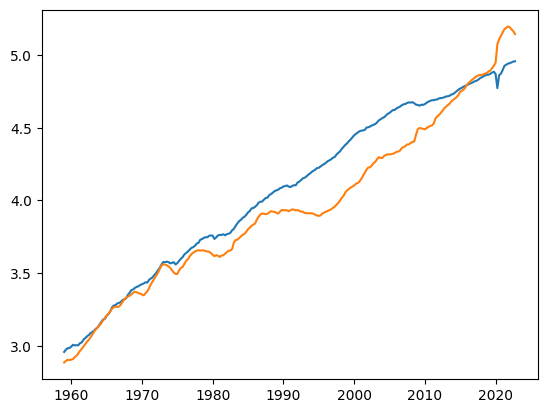

In [69]:
plt.plot(C.index[-256:], np.log(c))
plt.plot(C.index[-256:], np.log(m))

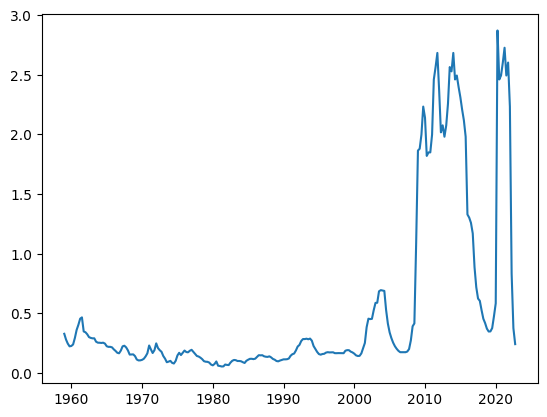

In [68]:
plt.plot(C.index[-256:], np.log((i + 1) / i))

In [28]:
est_param('1960-01-01', '1969-10-01', '1969-12-01');

intercept: -0.5723 
coefficients: [1.1595, 0.145]
gamma: 6.8985 
phi: 0.0193 
sigma: 7.9988


In [29]:
est_param('1970-01-01', '1979-10-01', '1979-12-01');

intercept: 0.1707 
coefficients: [0.9269, 0.2606]
gamma: 3.8379 
phi: 1.9256 
sigma: 3.5575


In [30]:
est_param('1980-01-01', '1989-10-01', '1989-12-01');

intercept: 0.4507 
coefficients: [0.8284, 0.9471]
gamma: 1.0558 
phi: 1.6093 
sigma: 0.8746


In [31]:
est_param('1990-01-01', '1999-10-01', '1999-12-01');

intercept: 2.2286 
coefficients: [0.4128, -0.1223]
gamma: -8.1786 
phi: 0.0 
sigma: -3.3761


In [32]:
est_param('2000-01-01', '2009-10-01', '2009-12-01');

intercept: -1.003 
coefficients: [1.15, 0.0757]
gamma: 13.2093 
phi: 0.0 
sigma: 15.1908


In [33]:
est_param('2010-01-01', '2019-10-01', '2019-12-01');

intercept: -6.5928 
coefficients: [2.3599, 0.04]
gamma: 24.9868 
phi: 0.0 
sigma: 58.9663


### Part (c)

In [34]:
# calculate seignorage in pieces

## Problem 2: SVAR impulse response to monetary shocks